In [1]:
import pandas as pd
import psycopg2 as pg
import numpy as np
import datetime

In [2]:
pd.options.display.max_columns = 30
!wget https://data.baltimorecity.gov/api/views/n4ma-fj3m/rows.csv?accessType=DOWNLOAD -O Parking_Citations.csv

--2016-12-02 20:55:23--  https://data.baltimorecity.gov/api/views/n4ma-fj3m/rows.csv?accessType=DOWNLOAD
Resolving data.baltimorecity.gov (data.baltimorecity.gov)... 52.206.140.199
Connecting to data.baltimorecity.gov (data.baltimorecity.gov)|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘Parking_Citations.csv’

Parking_Citations.c     [ <=>                  ] 143.08M  1.84MB/s   in 88s    

Last-modified header invalid -- time-stamp ignored.
2016-12-02 20:56:51 (1.63 MB/s) - ‘Parking_Citations.csv’ saved [150033075]



In [3]:
df = pd.read_csv('Parking_Citations.csv')

/opt/conda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.dtypes


Citation             int64
Tag                 object
ExpMM               object
ExpYY              float64
State               object
Make                object
Address             object
ViolCode           float64
Description         object
ViolFine            object
ViolDate            object
Balance             object
PenaltyDate        float64
OpenFine            object
OpenPenalty         object
NoticeDate          object
ImportDate          object
Neighborhood        object
PoliceDistrict      object
CouncilDistrict    float64
Location            object
dtype: object

In [5]:
# create a 2016 subset
df.ViolDate = pd.to_datetime(df.ViolDate, format="%m/%d/%Y %H:%M:%S %p")
# split Location
df.set_index('ViolDate', inplace=True)
df = df['2016']
df.reset_index(inplace=True)


In [6]:
df.shape

(319688, 21)

In [7]:
# convert to date type
df.ImportDate = df.ImportDate.str.replace(' \+0000', '')
df.NoticeDate = pd.to_datetime(df.NoticeDate, format="%m/%d/%Y")
df.PenaltyDate = pd.to_datetime(df.PenaltyDate, format="%m/%d/%Y")
df.ImportDate = pd.to_datetime(df.ImportDate, format="%m/%d/%Y %H:%M:%S %p")
# split Location
df['Latitude'] = df.Location.str.split(',').str.get(0).str.replace('\(','').map(lambda s: float(s))
df['Longitude'] = df.Location.str.split(',').str.get(1).str.replace('\)','').map(lambda s: float(s))
# remove $ sign
df[['ViolFine', 'Balance','OpenFine','OpenPenalty']] = df[['ViolFine', 'Balance','OpenFine','OpenPenalty']].applymap(lambda s: float(str(s).replace('$', '')))


In [8]:
# Clean EXP_MM 
mm_map = {val: val for val in df.ExpMM.unique()}
mm_map

{nan: nan,
 '01': '01',
 '10': '10',
 3.0: 3.0,
 4.0: 4.0,
 5.0: 5.0,
 6.0: 6.0,
 1.0: 1.0,
 8.0: 8.0,
 '12': '12',
 '09': '09',
 11.0: 11.0,
 12.0: 12.0,
 2.0: 2.0,
 9.0: 9.0,
 '04': '04',
 '03': '03',
 '11': '11',
 0.0: 0.0,
 '07': '07',
 '05': '05',
 7.0: 7.0,
 '06': '06',
 '00': '00',
 10.0: 10.0,
 '02': '02',
 '08': '08',
 'PE': 'PE'}

#####  use 9999 to indictate not a number
#####   use 888 to indiecate permanent 
#####   leave 0 intact since i do not know what it means

In [9]:
mm_map[np.nan] = 9999
mm_map['PE'] = 888
df.ExpMM = df.ExpMM.map(mm_map)
df.ExpMM = df.ExpMM.astype(int)
df.ExpMM.unique()

array([   2,   11,    9,   10, 9999,   12,    1,    5,    4,    3,    8,
          6,    7,  888,    0])

In [10]:
df.ExpYY = df.ExpYY.astype(int)
df.Citation = df.Citation.astype(str)
df.ViolCode = df.ViolCode.astype(str)
df.CouncilDistrict = df.CouncilDistrict.astype(str)

In [11]:
df.dtypes

ViolDate           datetime64[ns]
Citation                   object
Tag                        object
ExpMM                       int64
ExpYY                       int64
State                      object
Make                       object
Address                    object
ViolCode                   object
Description                object
ViolFine                  float64
Balance                   float64
PenaltyDate        datetime64[ns]
OpenFine                  float64
OpenPenalty               float64
NoticeDate         datetime64[ns]
ImportDate         datetime64[ns]
Neighborhood               object
PoliceDistrict             object
CouncilDistrict            object
Location                   object
Latitude                  float64
Longitude                 float64
dtype: object

##### Replace null values based on datatype

In [12]:
rep_na = {
    "datetime64[ns]": datetime.datetime(9999,12,31),
    "object" :  "unknown",
    "float64" : np.nan,
    "int64" : np.nan,
}

In [13]:
for c, t in zip(df.columns, df.dtypes):
    df[c].fillna(rep_na[str(t)], inplace = True)

In [14]:
df.to_csv("clean_data.csv", index=False, header=True)

In [15]:
%load_ext sql
!echo 'redspot' | sudo -S service postgresql restart
!createdb -U dbuser project3

/opt/conda/lib/python3.5/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/opt/conda/lib/python3.5/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


[sudo] password for jovyan: Restarting PostgreSQL 9.5 database server: main.


In [16]:
%sql postgresql://dbuser@localhost:5432/project3

'Connected: dbuser@project3'

In [17]:
%%sql
DROP TABLE IF EXISTS citation;
CREATE TABLE citation (
    violdate TIMESTAMP,
    citation Varchar(9),
    tag Varchar(9),
    expmm Integer,
    expyy Integer,
    state Varchar(2),
    make Varchar(20),
    address Varchar(255),
    violcode Varchar(25),
    description Varchar(255),
    violfine Real,
    balance Real,
    penaltydate TIMESTAMP,
    openfine Real,
    openpenalty Real,
    noticedate TIMESTAMP,
    importdate TIMESTAMP,
    neighborhood Varchar(100),
    policedistrict Varchar(100),
    councildistrict Varchar(25),
    location Varchar(255),
    latitude Float8,
    longitude Float8,
    Primary Key(citation)
);

Done.
Done.


[]

In [18]:
!pwd

/home/jovyan/work


In [19]:
%%sql
COPY citation FROM '/home/jovyan/work/clean_data.csv'
CSV
HEADER
QUOTE '"'
DELIMITER ',';

IntegrityError: (psycopg2.IntegrityError) duplicate key value violates unique constraint "citation_pkey"
DETAIL:  Key (citation)=(90668410) already exists.
CONTEXT:  COPY citation, line 152066
 [SQL: 'COPY citation FROM \'/home/jovyan/work/clean_data.csv\'\nCSV\nHEADER\nQUOTE \'"\'\nDELIMITER \',\';']

In [20]:
df[df.Citation == '90668410']

,ViolDate,Citation,Tag,ExpMM,ExpYY,State,Make,Address,ViolCode,Description,ViolFine,Balance,PenaltyDate,OpenFine,OpenPenalty,NoticeDate,ImportDate,Neighborhood,PoliceDistrict,CouncilDistrict,Location,Latitude,Longitude
122702,2016-03-31 11:59:00,90668410,HAZ2149,8,17,NY,VOLKS,4500 CHARLES ST,16.0,In Transit Zone/Stop,77.0,77.0,9999-12-31 00:00:00,77.0,0.0,9999-12-31 00:00:00,2016-04-02 11:01:00,unknown,unknown,nan,unknown,NaN,NaN
152064,2016-03-31 11:59:00,90668410,HAZ2149,8,17,NY,VOLKS,4500 CHARLES ST,16.0,In Transit Zone/Stop,77.0,0.0,9999-12-31 00:00:00,0.0,0.0,9999-12-31 00:00:00,2016-04-21 04:02:00,unknown,unknown,nan,unknown,NaN,NaN


In [21]:
df.duplicated(['Citation'], keep=False).sum()

16

In [22]:
df[df.duplicated(['Citation'], keep=False)]

,ViolDate,Citation,Tag,ExpMM,ExpYY,State,Make,Address,ViolCode,Description,ViolFine,Balance,PenaltyDate,OpenFine,OpenPenalty,NoticeDate,ImportDate,Neighborhood,PoliceDistrict,CouncilDistrict,Location,Latitude,Longitude
2336,2016-03-07 04:59:00,872119,6AL4573,11,15,MD,NISS,1110 S POTOMAC ST,22.0,Expired Tags,32.0,32.0,9999-12-31 00:00:00,32.0,0.0,9999-12-31 00:00:00,2016-04-02 11:01:00,unknown,unknown,nan,unknown,NaN,NaN
2337,2016-03-07 05:26:00,872135,52601M9,2,16,MD,MAZDA,E/S 1000 BLK ROBINSON S,22.0,Expired Tags,32.0,32.0,9999-12-31 00:00:00,32.0,0.0,9999-12-31 00:00:00,2016-04-02 11:01:00,unknown,unknown,nan,unknown,NaN,NaN
2338,2016-03-07 05:28:00,872143,52601M9,2,16,MD,MAZDA,E/S 1000 S ROBINSON ST,19.0,Exceeding 48 Hours,32.0,32.0,9999-12-31 00:00:00,32.0,0.0,9999-12-31 00:00:00,2016-04-02 11:01:00,unknown,unknown,nan,unknown,NaN,NaN
2339,2016-03-07 06:48:00,872150,9AV6732,8,15,MD,HOND,1300 S ELLWOOD AV,22.0,Expired Tags,32.0,32.0,9999-12-31 00:00:00,32.0,0.0,9999-12-31 00:00:00,2016-04-02 11:01:00,unknown,unknown,nan,unknown,NaN,NaN
2340,2016-03-10 08:53:00,872192,49394M4,10,15,MD,JEEP,E/S 3032 ELLIOTT ST,22.0,Expired Tags,32.0,32.0,9999-12-31 00:00:00,32.0,0.0,9999-12-31 00:00:00,2016-04-02 11:01:00,unknown,unknown,nan,unknown,NaN,NaN
2341,2016-03-11 10:58:00,872226,JKN8018,9,15,PA,FORD,901 POTOMAC ST,22.0,Expired Tags,32.0,32.0,9999-12-31 00:00:00,32.0,0.0,9999-12-31 00:00:00,2016-04-02 11:01:00,unknown,unknown,nan,unknown,NaN,NaN
5202,2016-03-03 05:50:00,2006716,4CF9258,2,16,MD,HOND,100 ALBEMARLE ST,22.0,Expired Tags,32.0,32.0,9999-12-31 00:00:00,32.0,0.0,9999-12-31 00:00:00,2016-04-02 11:01:00,unknown,unknown,nan,unknown,NaN,NaN
122702,2016-03-31 11:59:00,90668410,HAZ2149,8,17,NY,VOLKS,4500 CHARLES ST,16.0,In Transit Zone/Stop,77.0,77.0,9999-12-31 00:00:00,77.0,0.0,9999-12-31 00:00:00,2016-04-02 11:01:00,unknown,unknown,nan,unknown,NaN,NaN
152064,2016-03-31 11:59:00,90668410,HAZ2149,8,17,NY,VOLKS,4500 CHARLES ST,16.0,In Transit Zone/Stop,77.0,0.0,9999-12-31 00:00:00,0.0,0.0,9999-12-31 00:00:00,2016-04-21 04:02:00,unknown,unknown,nan,unknown,NaN,NaN
161774,2016-03-07 04:59:00,872119,6AL4573,11,17,MD,NISS,1110 S POTOMAC ST,22.0,Expired Tags,32.0,144.0,9999-12-31 00:00:00,32.0,96.0,2016-04-20 00:00:00,2016-10-12 04:02:00,unknown,unknown,nan,unknown,NaN,NaN


In [23]:
df.drop_duplicates(['Citation'], keep='last', inplace=True)

In [24]:
df.to_csv("clean_data.csv", index=False, header=True)

In [25]:
%%sql
COPY citation FROM '/home/jovyan/work/clean_data.csv'
CSV
HEADER
QUOTE '"'
DELIMITER ',';

319680 rows affected.


[]

In [26]:
%%sql
Select *
From citation
Limit 5;

5 rows affected.


violdate,citation,tag,expmm,expyy,state,make,address,violcode,description,violfine,balance,penaltydate,openfine,openpenalty,noticedate,importdate,neighborhood,policedistrict,councildistrict,location,latitude,longitude
2016-07-02 02:27:00,3450277,7BN7407,7,16,MD,SUBA,HOLIDAY,8.0,No Stopping/Standing Tow Away Zone,52.0,0.0,9999-12-31 00:00:00,0.0,0.0,2016-08-03 00:00:00,2016-10-15 04:02:00,unknown,unknown,nan,unknown,None,None
2016-03-15 10:50:00,96192399,1CA9164,10,15,MD,CADIL,1300 PARK AVE,22.0,Expired Tags,32.0,0.0,9999-12-31 00:00:00,0.0,0.0,2016-04-13 00:00:00,2016-06-07 04:01:00,unknown,unknown,nan,unknown,None,None
2016-09-14 09:40:00,97915038,2CF8876,4,17,MD,OLDSM,3702 CHESHOLM RD,19.0,Exceeding 48 Hours,32.0,0.0,9999-12-31 00:00:00,32.0,0.0,9999-12-31 00:00:00,2016-09-16 04:02:00,unknown,unknown,nan,unknown,None,None
2016-07-02 09:49:00,97036785,6ETF80,2,17,MD,LEXUS,400 ST PAUL PL,18.0,All Other Parking Meter Violations,32.0,0.0,9999-12-31 00:00:00,32.0,48.0,2016-07-20 00:00:00,2016-10-12 04:02:00,unknown,unknown,nan,unknown,None,None
2016-06-15 01:31:00,97059282,GLB4684,11,17,NY,KIA,800 BATTERY AVE,11.0,Residential Parking Permit Only,52.0,0.0,9999-12-31 00:00:00,52.0,0.0,9999-12-31 00:00:00,2016-10-18 04:01:00,unknown,unknown,nan,unknown,None,None


In [27]:
%matplotlib inline

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Explore the top 10 violations that result in the most amount of fine.

In [28]:
%%sql
select description, sum(violfine) as Total_Viol_Fine
from citation
group by description
order by Total_Viol_Fine desc limit 10;


10 rows affected.


description,total_viol_fine
All Other Parking Meter Violations,3509060.0
No Stop/Park Street Cleaning,2190500.0
No Stopping/Standing Tow Away Zone,1762910.0
Residential Parking Permit Only,1248520.0
No Stopping/Standing Not Tow-Away Zone,1115780.0
No Stop/Park Handicap,1031910.0
Expired Tags,975729.0
Abandonded Vehicle,569572.0
In Transit Zone/Stop,444521.0
Obstruct/Impeding Movement of Pedestrian,419881.0


<Container object of 10 artists>

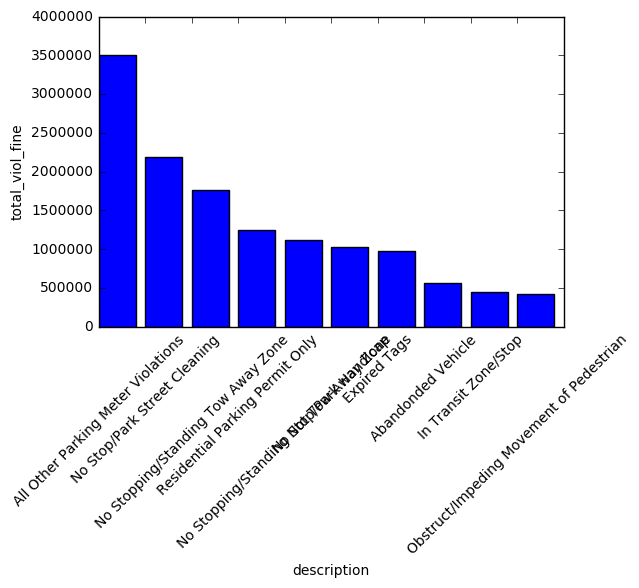

In [29]:
result = _
result.bar()

Similarly, explore the top 10 violations that have the most total amount of open fine.

In [30]:
%%sql
select description, sum(openfine) as Total_Open_Fine
from citation
group by description
order by Total_Open_Fine desc limit 10;

10 rows affected.


description,total_open_fine
All Other Parking Meter Violations,1337440.0
No Stop/Park Street Cleaning,1007310.0
No Stopping/Standing Tow Away Zone,677603.0
Expired Tags,553392.0
No Stop/Park Handicap,542735.0
Residential Parking Permit Only,474128.0
Abandonded Vehicle,444119.0
No Stopping/Standing Not Tow-Away Zone,418578.0
All Other Stopping or Parking Violations,193808.0
In Transit Zone/Stop,190778.0


<Container object of 10 artists>

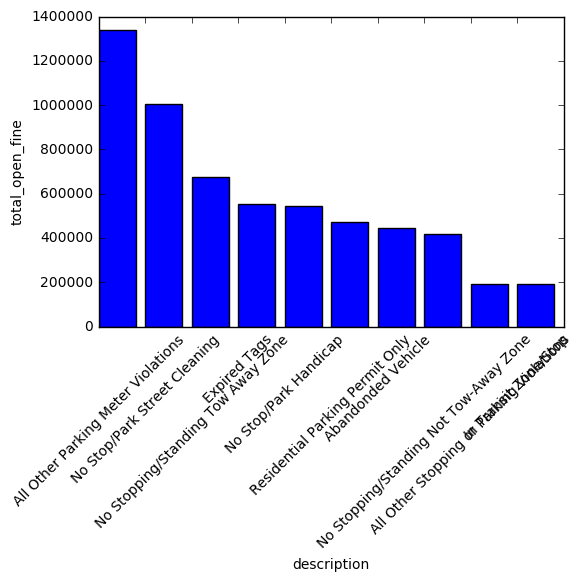

In [31]:
result = _
result.bar()

Top 10 states that have the most number of violations

In [32]:
%%sql
select state, count(violcode) as Total_Violations
from citation
group by state
order by Total_Violations desc limit 10;

10 rows affected.


state,total_violations
MD,268647
VA,8618
PA,8519
NJ,3650
NY,3448
FL,2459
TN,2362
NC,2171
DC,2120
DE,1813


<Container object of 10 artists>

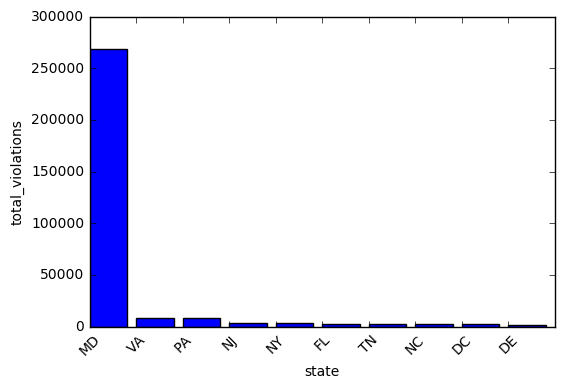

In [33]:
result = _
result.bar()

The state of Maryland seems to have the most number of violations by orders of magnitude. Its total is over 250,000 records while the other states are less than 10,000. The next step is subsetting the data for Maryland specifically to provide further details to reveal the nature of the violations.

In [34]:
%%sql
select description, sum(violfine) as Total_Viol_Fine
from citation
where state = 'MD'
group by description
order by Total_Viol_Fine desc limit 10
;

10 rows affected.


description,total_viol_fine
All Other Parking Meter Violations,2987300.0
No Stop/Park Street Cleaning,1903510.0
No Stopping/Standing Tow Away Zone,1477900.0
Residential Parking Permit Only,992056.0
No Stopping/Standing Not Tow-Away Zone,935241.0
No Stop/Park Handicap,906910.0
Expired Tags,847441.0
Abandonded Vehicle,477462.0
In Transit Zone/Stop,367829.0
Obstruct/Impeding Movement of Pedestrian,357742.0


In [36]:
%%sql
create table MD as 
select description, sum(violfine) as Total_Viol_Fine
from citation
where state = 'MD'
group by description
order by Total_Viol_Fine desc limit 10
;

10 rows affected.


[]

In [49]:
%%sql
drop table if exists other_states;
    create table other_states as 
    select state, description, sum(violfine) as Total_Viol_Fine
    from citation
    where state != 'MD'
    group by state, description
    order by Total_Viol_Fine desc limit 10
;

Done.
10 rows affected.


[]

In [50]:
%%sql
select *
from other_states;

10 rows affected.


state,description,total_viol_fine
VA,All Other Parking Meter Violations,104896.0
PA,All Other Parking Meter Violations,88928.0
PA,No Stop/Park Street Cleaning,48932.0
VA,No Stop/Park Street Cleaning,48724.0
VA,No Stopping/Standing Tow Away Zone,47268.0
PA,No Stopping/Standing Tow Away Zone,45344.0
PA,Residential Parking Permit Only,43264.0
NJ,All Other Parking Meter Violations,41248.0
TN,All Other Stopping or Parking Violations,40320.0
VA,Residential Parking Permit Only,38584.0


The result of the query below shows that Maryland and other states share quite a few common violations because the total of top 10 violations from both tables turn out to be 11. 

In [51]:
%%sql
select description from MD
union 
select description from other_states;

11 rows affected.


description
All Other Parking Meter Violations
No Stop/Park Handicap
No Stopping/Standing Not Tow-Away Zone
Expired Tags
Residential Parking Permit Only
In Transit Zone/Stop
No Stop/Park Street Cleaning
Obstruct/Impeding Movement of Pedestrian
All Other Stopping or Parking Violations
No Stopping/Standing Tow Away Zone


To see the different violations that do not occur in one or the other, the following list provdies details.

In [57]:
%%sql
SELECT  description from MD
except 
select description from other_states
;

6 rows affected.


description
Obstruct/Impeding Movement of Pedestrian
No Stop/Park Handicap
No Stopping/Standing Not Tow-Away Zone
Expired Tags
Abandonded Vehicle
In Transit Zone/Stop
